In [1]:
import rebound
%matplotlib inline
import matplotlib.pyplot as plt
import observations
import state
import mcmc
import numpy as np
import corner

/Users/rein/git/rebound/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Setting up fake observations

In [2]:
true_state = state.State(planets=[{"m":1e-3, "a":1., "h":0.2, "k":0.0, "l":0.}])
obs = observations.FakeObservation(true_state, Npoints=100, error=1e-4, tmax=10.)

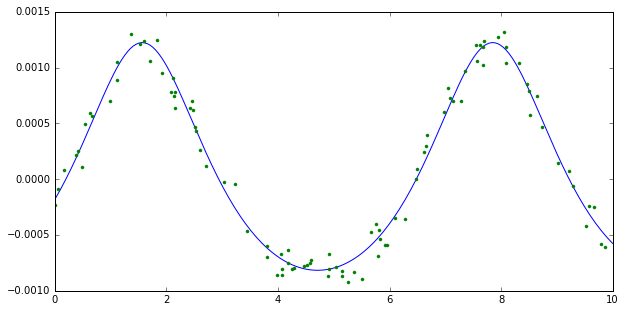

In [3]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.plot(*true_state.get_rv_plotting(tmax=10.))
ax.plot(obs.t, obs.rv, ".")

# SMALA 
Starting from exact solution.

In [19]:
s = state.StateVar(planets=[{"m":1e-3, "a":1., "h":0.2, "k":0.0, "l":0.}], ignore_vars=[])
smala = mcmc.Smala(s,obs)
Niter = 1000
chain = np.zeros((Niter,s.Nvars))
chainlogp = np.zeros(Niter)
tries = 0
for i in range(Niter):
    tries += smala.step_force()
    chain[i] = smala.state.get_params()
    chainlogp[i] = smala.state.logp
print("Acceptance rate: %.2f%%"%(float(Niter)/tries*100))

Acceptance rate: 81.23%


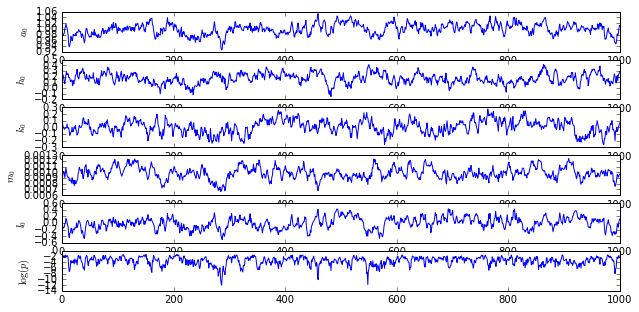

In [20]:
fig = plt.figure(figsize=(10,5))
for i in range(s.Nvars):
    ax = plt.subplot(s.Nvars+1,1,1+i)
    ax.set_ylabel(s.get_keys()[i])
    ax.plot(chain[:,i])
ax = plt.subplot(s.Nvars+1,1,s.Nvars+1)
ax.set_ylabel("$\log(p)$")
ax.plot(chainlogp)    

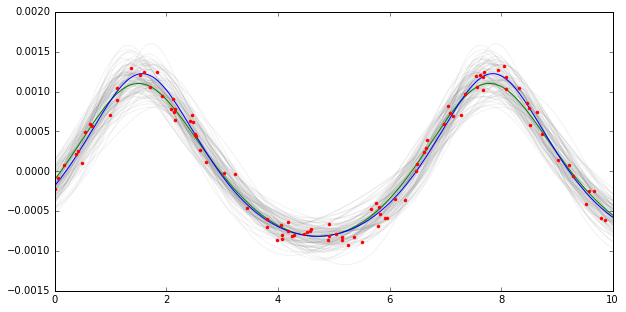

In [21]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
for c in np.random.choice(Niter,100):
    s = smala.state.deepcopy()
    s.set_params(chain[c])
    ax.plot(*s.get_rv_plotting(tmax=10.), alpha=0.1, color="gray")
s = smala.state.deepcopy()
s.set_params(chain[0])
ax.plot(*s.get_rv_plotting(tmax=10.), color="green")
ax.plot(*true_state.get_rv_plotting(tmax=10.), color="blue")
ax.plot(obs.t, obs.rv, "r.")    

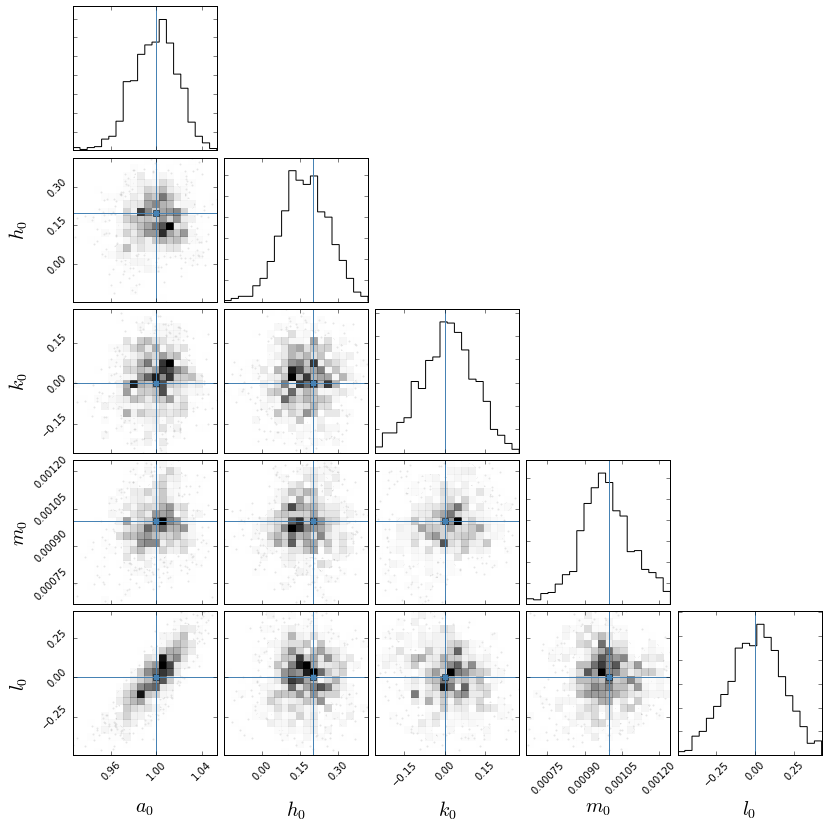

In [22]:
figure = corner.corner(chain, labels=s.get_keys(), plot_contours=False, truths=true_state.get_params(),label_kwargs={"fontsize":20})

# Metropolis Hastings
Starting from a very true initial set of parameters.

In [12]:
s = state.StateVar(planets=[{"m":1e-3, "a":1., "h":0.2, "k":0.0, "l":0.}], ignore_vars=[],)
mh = mcmc.Mh(s,obs)
mh.set_scales({"m":1e-3, "a":1., "h":0.5, "k":0.5, "l":np.pi})
mh.step_size = 4e-2
Niter = 1000
chain = np.zeros((Niter,s.Nvars))
chainlogp = np.zeros(Niter)
tries = 0
for i in range(Niter):
    tries += mh.step_force()
    chain[i] = mh.state.get_params()
    chainlogp[i] = mh.state.logp
print("Acceptance rate: %.2f%%"%(float(Niter)/tries*100))

Acceptance rate: 25.22%


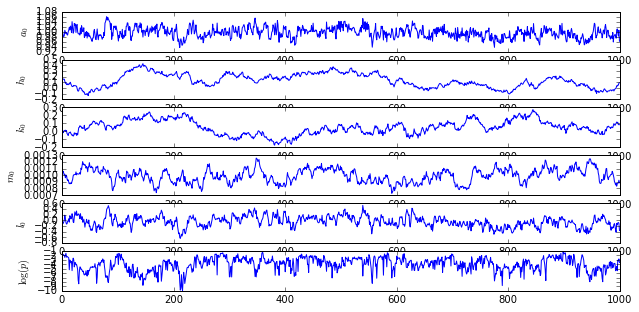

In [13]:
fig = plt.figure(figsize=(10,5))
for i in range(s.Nvars):
    ax = plt.subplot(s.Nvars+1,1,1+i)
    ax.set_ylabel(s.get_keys()[i])
    ax.plot(chain[:,i])    
ax = plt.subplot(s.Nvars+1,1,s.Nvars+1)
ax.set_ylabel("$\log(p)$")
ax.plot(chainlogp)    

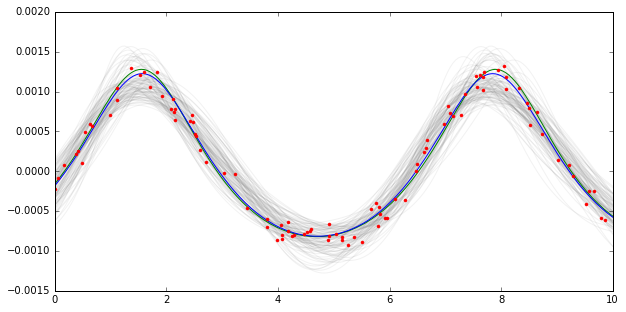

In [14]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
for c in np.random.choice(Niter,100):
    s = mh.state.deepcopy()
    s.set_params(chain[c])
    ax.plot(*s.get_rv_plotting(tmax=10.), alpha=0.1, color="gray")
s = mh.state.deepcopy()
s.set_params(chain[0])
ax.plot(*s.get_rv_plotting(tmax=10.), color="green")
ax.plot(*true_state.get_rv_plotting(tmax=10.), color="blue")
ax.plot(obs.t, obs.rv, "r.")    

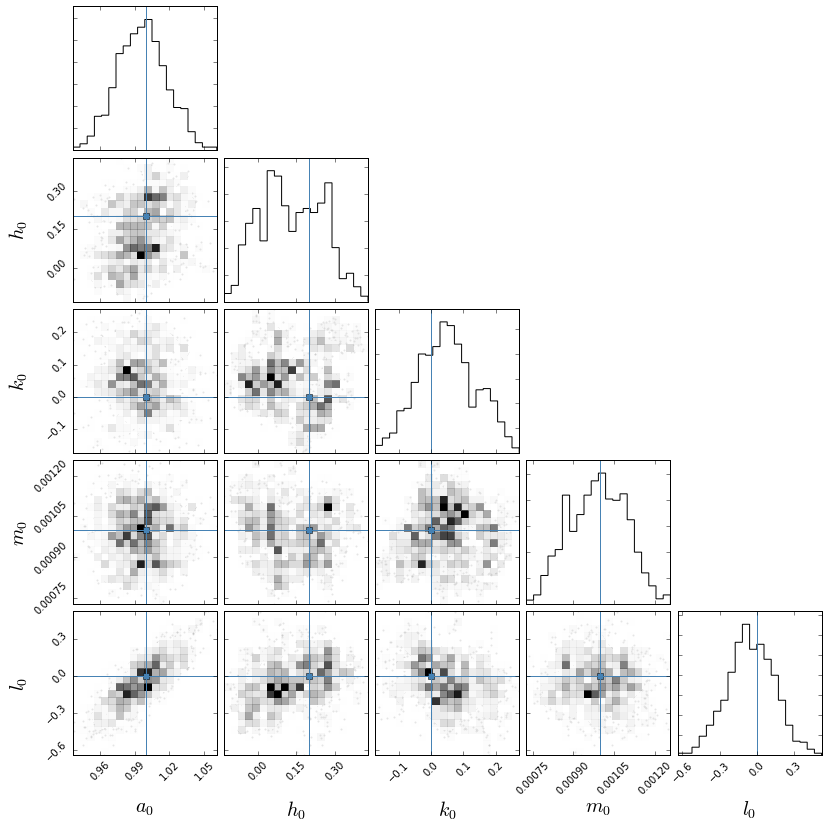

In [17]:
figure = corner.corner(chain, labels=s.get_keys(), plot_contours=False, truths=true_state.get_params(),label_kwargs={"fontsize":20})